In [2]:
import import_ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train_data => data, target분리

In [3]:
data_org=pd.read_csv('./housing/train.csv')
data = data_org.copy()
data.drop(['id'],axis=1,inplace=True)
target=data[['target']]
data.drop(['target'],axis=1,inplace=True)

test_data => test_data

In [27]:
test = pd.read_csv('./housing/test.csv')
x_feature = data.columns
test_data = test[x_feature]

#test data 전처리
data[data.columns[data.dtypes=='object']]=data[test_data.columns[data.dtypes=='object']].applymap(lambda x : ['Po','Fa','TA','Gd','Ex'].index(x))
test_data[test_data.columns[test_data.dtypes=='object']]=test_data[test_data.columns[test_data.dtypes=='object']].applymap(lambda x : ['Po','Fa','TA','Gd','Ex'].index(x))

C:\Python39\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### 데이터 전처리

#피처 스케일링
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def scaling(data):
    columns = data.columns
    data=scaler.fit_transform(data)
    data = pd.DataFrame(data)
    data.columns = columns
    return data

data= scaling(data)
test_data = scaling(test_data)

In [29]:
mean = data.mean(axis=0)
data -= mean
std = data.std()
data /=std

test_data -=mean
test_data /=std

In [30]:
test_data

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt
0,2.086009,0.587578,1.000546,0.198671,1.044910,2.177086,1.867784,1.686460,2.003231,0.796270,1.160552,1.086710,1.124161
1,-0.156118,-0.885173,-0.742341,-1.333936,-1.369010,-0.838887,-0.001678,-0.227894,-0.873749,-1.016486,-0.852601,-1.741618,-1.200753
2,-0.156118,0.121959,1.000546,0.198671,-0.324023,0.669099,-0.850487,-1.062424,0.564741,0.796270,0.921703,0.739372,0.848324
3,-0.156118,1.906489,1.000546,1.731279,1.264357,0.669099,0.196204,-0.025260,0.564741,0.796270,1.058188,0.937851,1.005945
4,-0.903494,-0.971322,-0.742341,0.198671,0.961311,-0.838887,-0.111034,-0.339875,-0.873749,-1.016486,-0.170177,-0.848462,0.493676
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,1.338633,0.858334,2.743433,1.731279,1.421105,2.177086,2.211473,2.038402,2.003231,0.796270,1.194673,1.136330,1.163566
1346,-0.903494,-1.233874,-0.742341,-1.333936,-1.118213,-0.838887,-0.444308,-0.681153,-0.873749,-1.016486,-0.306661,-1.046941,-0.570268
1347,-1.650870,-1.338484,-0.742341,0.198671,-1.118213,-0.838887,-0.577097,-0.817130,-2.312239,-1.016486,-1.807996,-1.741618,-2.304103
1348,-0.903494,-0.171360,-0.742341,0.198671,0.637365,0.669099,0.904412,0.699955,2.003231,0.796270,1.058188,0.987471,1.005945


In [8]:
target = np.log1p(target)
# 왜 target이 정규분포를 이루는게 좋을까?
#plt.hist(target,bins=100)

평가지표

In [10]:
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [11]:
def NMAE_R2(true, pred):
    mae = np.mean(np.abs(true-pred))
    abs_score = mae / np.mean(np.abs(true))
    r2score = r2_score(true,pred)
    
    return abs_score[0],r2score

In [12]:
model_rank = pd.DataFrame(columns=['NMAE score','R^2 score','cv score'])

def model_rank_add(model_name,NMAE_score,r2score,cvscore):
    if cvscore < -100:
        cvscore=100
    if r2score<-100:
        r2score=-100
    if NMAE_score>100:
        NMAE_score=100
    model_rank.loc[model_name]=[NMAE_score,r2score,cvscore]
    

In [47]:
def model_test(model,data,target,test_size,model_name):
    
    #모델 학습 & 예측
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=test_size,random_state=0)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    #Lasso 에서만 
    if(y_pred.ndim==1):
        y_pred=y_pred[:, np.newaxis]
    
    #평가값 계산
    abs_score,r2score=NMAE_R2(y_test,y_pred)
    cvscore = cross_val_score(model, data,target,cv=5).mean()
    
    print('NMAE SCORE : ', abs_score)
    print('R^2 SCORE : ',r2score)
    print('5- cvscore : {}'.format(cvscore.mean()))
    model_rank_add(model_name,round(abs_score,5),round(r2score,5),cvscore)
    
    dif = y_pred-y_test
    #dif.rename(columns={'target':'overvalued'},inplace=True)
    
    #그래프
    plt.figure(figsize=(15,15))
    plt.title(model_name)
    plt.xlabel('Actual Price')
    plt.ylabel('Error')
    plt.plot([y_test.min(),y_test.max()],[0,0],c='red')
    plt.scatter(y_test,dif,c='green')
    
    #plt.figure(figsize = (15,15))
    #plt.title(model_name)
    #plt.ylabel('Actual Price')
    #plt.xlabel('Expected Price')
    #plt.scatter(y_pred,y_test,c='green')
    
    return dif
    

### 1. 선형회귀

In [33]:
target

,target
0,386250
1,194000
2,123000
3,135000
4,250000
...,...
1345,204000
1346,390000
1347,143000
1348,131000


In [686]:
dif_percentage=pd.DataFrame(dif.abs()['overvalued'] / target['target'] * 100)

In [687]:
dif_percentage.columns = ['percentage']

In [688]:
dif_new=dif_percentage[dif_percentage.sort_values('percentage')>20].dropna()

In [609]:
gn=list(dif_new['index'])

In [610]:
wpqkf=list(map(int,gn))

In [611]:
boolean =[]
for i in range(0,len(data)):
    if i in wpqkf:
        boolean.append(True)
    else:
        boolean.append(False)
    

In [2]:
lr= LinearRegression()

NameError: name 'LinearRegression' is not defined

In [614]:
lr.fit(data[boolean],target[boolean])

LinearRegression()

In [1]:
y_pred = lr.predict(data)
dif = y_pred-target
dif.rename(columns={'target':'overvalued'},inplace=True)

#그래프
plt.figure(figsize=(15,15))
#plt.title(model_name)
plt.xlabel('Actual Price')
plt.ylabel('Error',)
#plt.plot([target.min(),target.max()],[0,0],c='red')
plt.scatter(dif,target,c='green')

NameError: name 'lr' is not defined

In [532]:
dif_percentage.reset_index(inplace=True)

In [533]:
dif_percentage

,index,percentage
0,0,10.769361
1,1,9.810861
2,2,13.726841
3,3,6.531177
4,4,10.781888
...,...,...
1189,1189,0.318629
1190,1190,5.562796
1191,1191,7.116048
1192,1192,4.965607


In [626]:
data1=data1.append(data[boolean])
target1 = target1.append(target[boolean])

In [16]:
lr = LinearRegression()
lr.fit(data,target)
y_pred = lr.predict(data)

dif = y_pred-target
dif.rename(columns={'target':'overvalued'},inplace=True)

#그래프
plt.figure(figsize=(15,15))
#plt.title(model_name)
plt.xlabel('Actual Price')
plt.ylabel('Error',)
plt.plot([target.min(),target.max()],[0,0],c='red')
plt.scatter(target,dif,c='green')

NameError: name 'LinearRegression' is not defined

In [34]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(data1,target1)
y_pred = lr.predict(data)

dif = y_pred-target
dif.rename(columns={'target':'overvalued'},inplace=True)

#그래프
plt.figure(figsize=(15,15))
#plt.title(model_name)
plt.xlabel('Actual Price')
plt.ylabel('Error',)
plt.plot([target.min(),target.max()],[0,0],c='red')
plt.scatter(target,dif,c='green')

NameError: name 'data1' is not defined

In [38]:
data=data.drop(['Garage Area','1st Flr SF', 'Garage Yr Blt'],axis=1)

In [39]:
data

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Kitchen Qual,Total Bsmt SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add
0,2.833385,1.801879,2.743433,1.731279,2.177086,3.409179,2.003231,0.796270,1.024067,0.888231
1,0.591257,-0.331353,1.000546,0.198671,0.669099,0.701323,2.003231,0.796270,1.126431,1.086710
2,-0.903494,-1.258488,-0.742341,-1.333936,-0.838887,-0.569286,-0.873749,-1.016486,-0.204298,-0.898082
3,-0.903494,-0.696464,-0.742341,0.198671,0.669099,-1.048368,-0.873749,-1.016486,-2.490421,1.037091
4,0.591257,0.911665,1.000546,1.731279,0.669099,-0.147486,0.564741,0.796270,1.092309,0.987471
...,...,...,...,...,...,...,...,...,...,...
1345,-0.156118,0.497326,1.000546,0.198671,-0.838887,-0.548457,2.003231,0.796270,0.785218,0.590512
1346,2.086009,2.532100,1.000546,1.731279,2.177086,1.997969,2.003231,0.796270,1.126431,1.037091
1347,-0.903494,-0.614416,-0.742341,-1.333936,-0.838887,0.342011,-0.873749,0.796270,-0.204298,-0.898082
1348,-0.903494,-1.270795,-0.742341,0.198671,-0.838887,-0.569286,0.564741,-1.016486,0.034551,-0.550743


In [59]:
model_rank

,NMAE score,R^2 score,cv score
LinearRegression,0.12050,0.82788,0.851518
PolynomialRegression,0.10070,0.87129,0.894482
PolynomialRegression3,0.11845,0.80676,0.776315
PolynomialRegression4,0.11845,0.80676,0.776315


NMAE SCORE :  0.120501176237888
R^2 SCORE :  0.827877620685828
5- cvscore : 0.8515180478986663


,0
Overall Qual,19863.052937
Gr Liv Area,32710.595342
Exter Qual,3810.813083
Garage Cars,5366.542178
Kitchen Qual,6666.613727
Total Bsmt SF,18322.448363
Bsmt Qual,10267.736655
Full Bath,-9195.792227
Year Built,3718.036440
Year Remod/Add,3207.898687


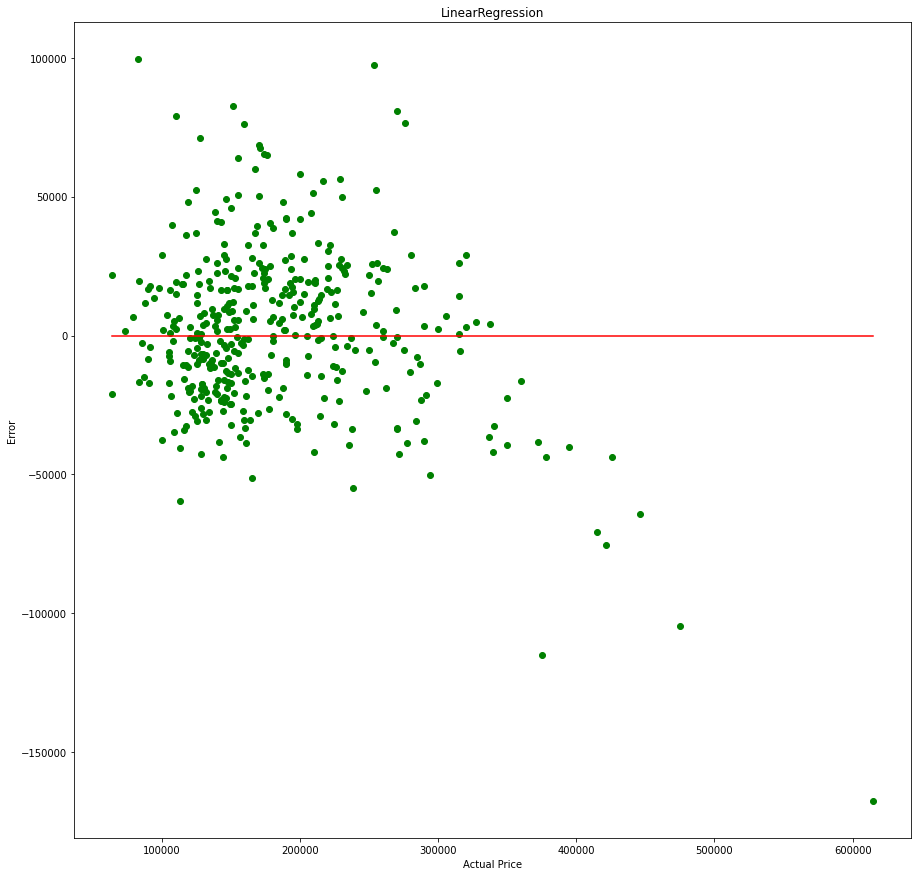

In [58]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

dif=model_test(lr,data,target,0.3,'LinearRegression')

coef=pd.DataFrame(lr.coef_,columns=data.columns)
coef.T

1. 결과 보면 왜 full bath가 음수가 나오는지 모르겠음 그나마 Gr Liv Area랑 겹쳐서 그런가..? 하 반대로 예측했었다 ;;

2. 대체로 낮은 가격대들은 낮게 예측하고 높은 가격대들은 높게 예측함.

In [427]:
#오차가 제일 큰 애들 20개

In [455]:
under_valued=dif.sort_values('overvalued').head(10)

In [457]:
over_valued = dif.sort_values('overvalued').tail(10)

In [458]:
under_valued

,overvalued
303,-76308.032516
1039,-68427.055311
1053,-64394.056709
260,-58683.480293
583,-53726.047432
990,-53548.028732
975,-50487.418552
681,-44797.533520
592,-42227.817804
999,-41715.433519


In [459]:
over_valued

,overvalued
601,42119.312560
188,44479.189913
861,45599.015729
308,46023.541528
936,54779.313092
397,57159.277331
520,62745.579383
706,65940.293486
202,76651.817660
200,80305.291331


In [468]:
target

,target
0,194000.0
1,123000.0
2,135000.0
3,269500.0
4,156500.0
...,...
1189,108500.0
1190,204000.0
1191,143000.0
1192,131000.0


In [469]:
data.loc[202],target.loc[202]

(Overall Qual     -0.866510
 Gr Liv Area       0.888851
 Exter Qual       -0.683191
 Garage Cars       2.203519
 Garage Area       2.758668
 Kitchen Qual     -0.787555
 Total Bsmt SF     1.735386
 1st Flr SF        2.170155
 Bsmt Qual        -0.832333
 Full Bath         0.927003
 Year Built       -0.471556
 Year Remod/Add   -1.269069
 Garage Yr Blt    -0.351513
 Name: 202, dtype: float64,
 target    110000.0
 Name: 202, dtype: float64)

In [471]:
data.loc[200]

Overall Qual      0.853545
Gr Liv Area       0.717064
Exter Qual        1.259023
Garage Cars       0.427016
Garage Area      -0.556423
Kitchen Qual      0.870895
Total Bsmt SF    -0.140854
1st Flr SF       -0.402082
Bsmt Qual         0.757756
Full Bath         0.927003
Year Built        1.145157
Year Remod/Add    1.004179
Garage Yr Blt     1.114567
Name: 200, dtype: float64

In [462]:
coef

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt
0,13956.884555,18878.877194,1283.655458,1301.108118,3240.325019,6240.369291,10047.417668,1443.91445,4904.286016,-3145.257662,8933.544697,2904.677525,-2167.608903


In [470]:
data.loc[202].dot(coef.T)

0    17136.148496
Name: 202, dtype: float64

In [ ]:
lr = LinearRegression()



### 2. 다항 회귀

In [42]:
from sklearn.preprocessing import PolynomialFeatures

# degree = 2 인 2차 다항식으로 X를 변환
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly2=poly_features.fit_transform(data)

In [43]:
X_poly2.shape # 13 C 2 6*13 = 78 , 78 + 13(제곱항) + 13(단일항)

(1350, 65)

NMAE SCORE :  0.1006970633817372
R^2 SCORE :  0.8712880343531785
5- cvscore : 0.8944820415806785


,overvalued
841,18164.509337
184,-685.267653
526,-7906.605259
1283,-1704.517756
980,-126934.995953
...,...
619,-13699.112337
122,-3469.851696
1015,1856.620499
990,-32457.530137


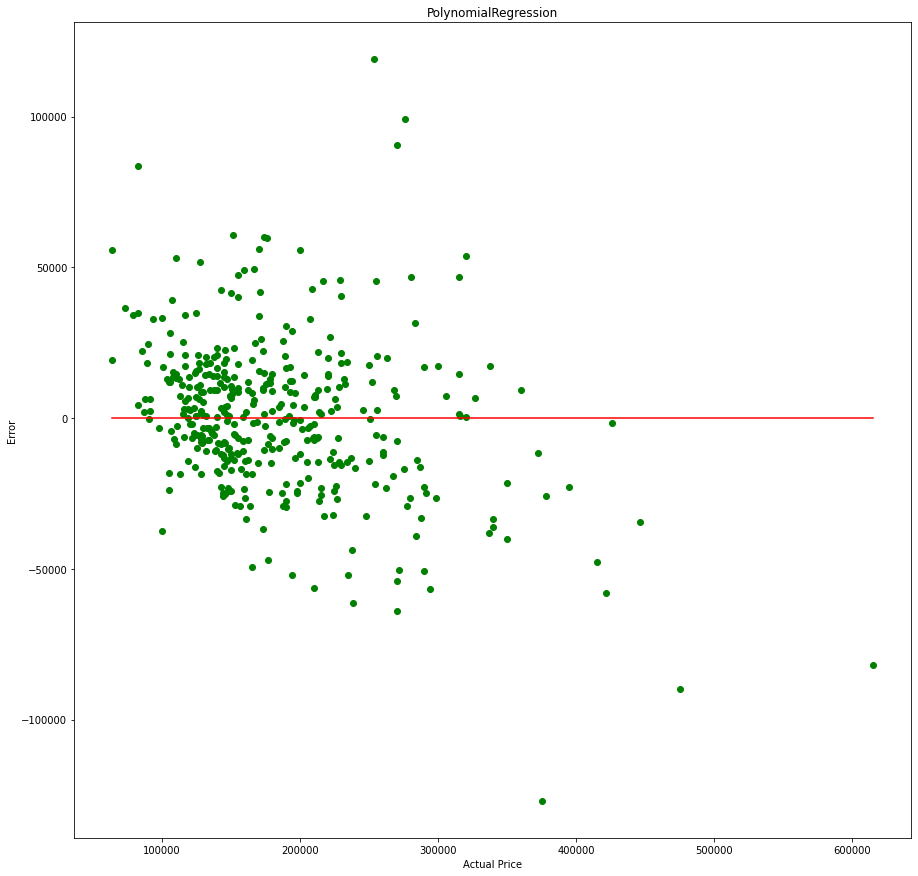

In [44]:
lr = LinearRegression()
model_test(lr,X_poly2,target,0.3,'PolynomialRegression')

1. 이것도 가격 낮은 애들은 낮게 예측하는 경향이 있으나 높은 애들은 꼭 높게 예측하진 않음

### degree 3인 경우에 오차가 더 큼 => 과도한 overfitting
### + R^2 <0 => 평균값으로 예측한 것보다 성능이 떨어짐

In [64]:
model_rank

,NMAE score,R^2 score,cv score
LinearRegression,0.1205,0.82788,0.851518
PolynomialRegression,0.1007,0.87129,0.894482
PolynomialRegression3,100.0000,-100.00000,100.000000
PolynomialRegression4,100.0000,-100.00000,100.000000


(1350, 285)
NMAE SCORE :  0.11844849696647164
R^2 SCORE :  0.8067571480798289
5- cvscore : 0.7763148250997242


,target
841,28489.104009
184,17999.500244
526,-10035.200007
1283,-3547.458273
980,-131052.268158
...,...
619,-8728.071398
122,1427.302779
1015,-43361.406008
990,-11505.814221


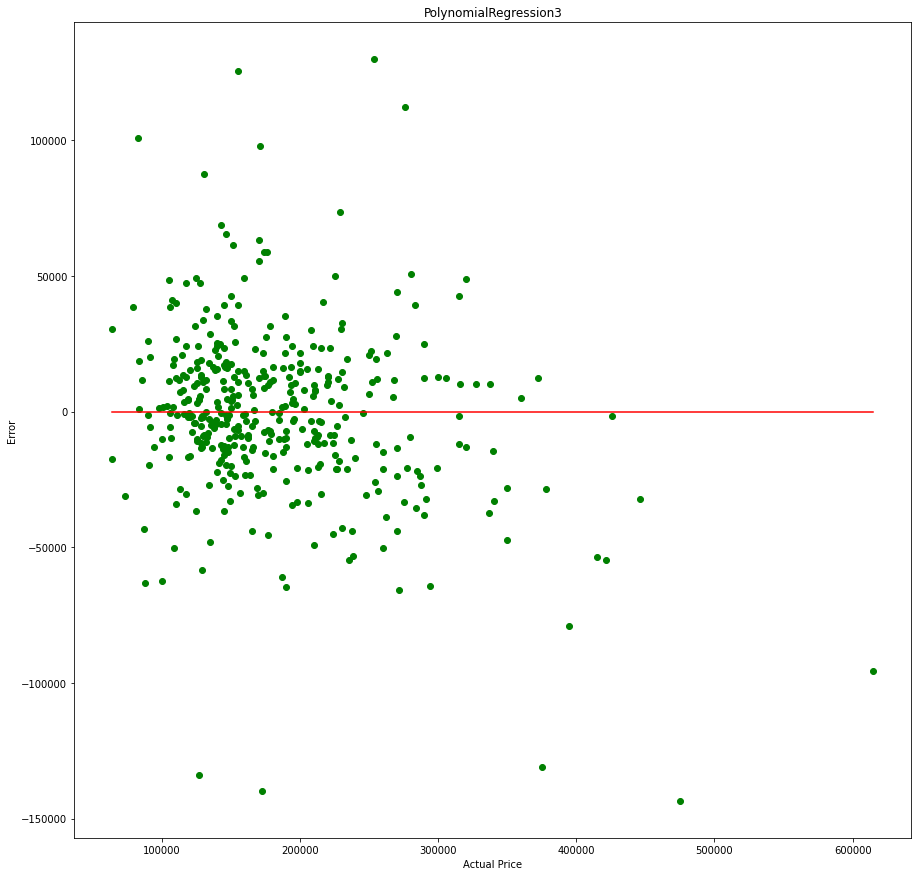

In [65]:
from sklearn.preprocessing import PolynomialFeatures

###degree = 3 인 3차 다항식으로 X를 변환
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly3=poly_features.fit_transform(data)
print(X_poly3.shape)

lr = LinearRegression()
model_test(lr,X_poly3,target,0.3,'PolynomialRegression3')

심각한 overfitting

Ridge

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge

In [352]:
from sklearn.model_selection import GridSearchCV

def best_params(model,param_grid):
    GS=GridSearchCV(model,
                 param_grid,
                 scoring = 'neg_mean_absolute_error',
                 cv=5)
    GS.fit(data,target)
    scores = pd.DataFrame(GS.cv_results_)
    scores['model'] = model
    
    return scores[['model','params','mean_fit_time','mean_test_score']].sort_values(by=['mean_test_score','mean_fit_time'],ascending=[False,True])

In [353]:
# 2차 norm ^2

In [354]:
alpha_params = [i/10 for i in range(0,10)]
alpha_params

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [355]:
rg=Ridge(random_state=0)
best_params(rg,{'alpha' : alpha_params})

,model,params,mean_fit_time,mean_test_score
9,Ridge(random_state=0),{'alpha': 0.9},0.002605,-16592.805157
8,Ridge(random_state=0),{'alpha': 0.8},0.002393,-16593.053620
7,Ridge(random_state=0),{'alpha': 0.7},0.003217,-16593.302333
6,Ridge(random_state=0),{'alpha': 0.6},0.002874,-16593.551296
5,Ridge(random_state=0),{'alpha': 0.5},0.003105,-16593.800509
4,Ridge(random_state=0),{'alpha': 0.4},0.003191,-16594.049974
3,Ridge(random_state=0),{'alpha': 0.3},0.003207,-16594.299691
2,Ridge(random_state=0),{'alpha': 0.2},0.004798,-16594.549661
1,Ridge(random_state=0),{'alpha': 0.1},0.004012,-16594.799883
0,Ridge(random_state=0),{'alpha': 0.0},0.004423,-16595.050359


NMAE SCORE :  0.12049112895744218
R^2 SCORE :  0.8279003599113708
5- cvscore : 0.8515267105990165
NMAE SCORE :  0.10064952248474068
R^2 SCORE :  0.8713590192953559
5- cvscore : 0.8945434476853353
NMAE SCORE :  0.11533288551036121
R^2 SCORE :  0.819058803953777
5- cvscore : 0.7920766347919848


,target
841,28704.274150
184,17388.522195
526,-9936.147197
1283,-3794.566149
980,-131092.534656
...,...
619,-9002.658659
122,-1168.490008
1015,-40277.921979
990,-13023.696277


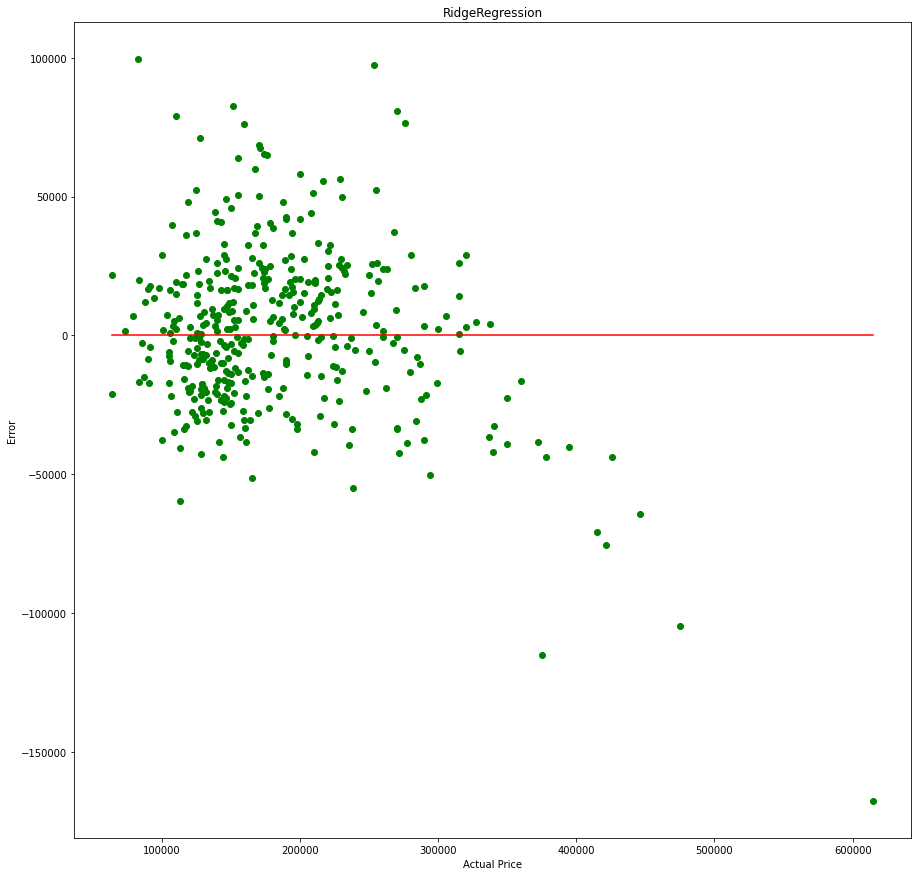

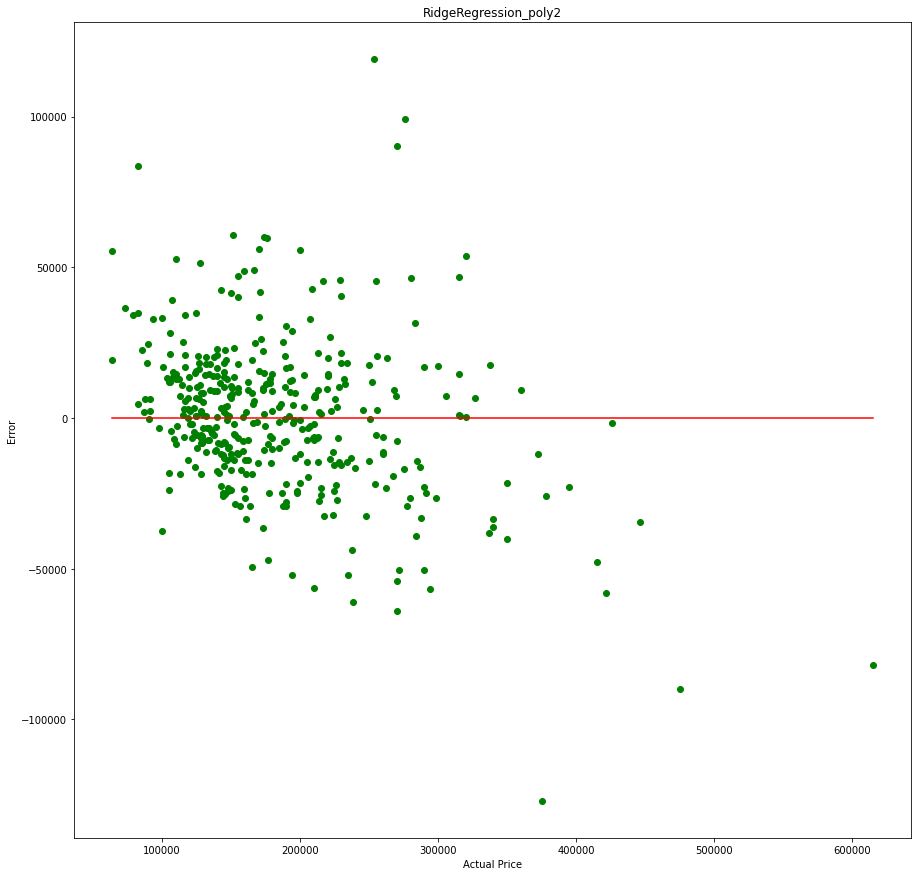

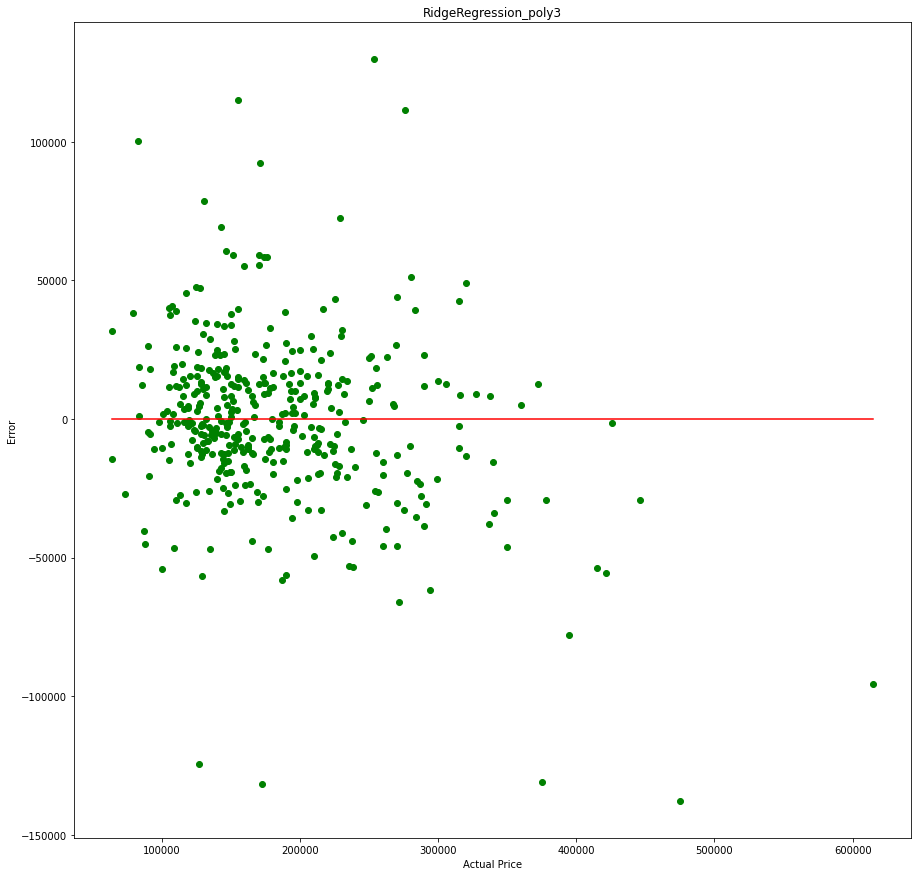

In [68]:
from sklearn.linear_model import Ridge


rg=Ridge(alpha=0.5,random_state=0)
model_test(rg,data,target,0.3,'RidgeRegression')

rg2=Ridge(alpha=0.5,max_iter=1000,random_state=0)
model_test(rg2,X_poly2,target,0.3,'RidgeRegression_poly2')

rg3=Ridge(alpha=0.5,max_iter=1000,random_state=0)
model_test(rg3,X_poly3,target,0.3,'RidgeRegression_poly3')

In [69]:
model_rank

,NMAE score,R^2 score,cv score
LinearRegression,0.12050,0.82788,0.851518
PolynomialRegression,0.10070,0.87129,0.894482
PolynomialRegression3,0.11845,0.80676,0.776315
PolynomialRegression4,100.00000,-100.00000,100.000000
SGERegressor,0.12018,0.82826,0.851679
SGERegressor+poly2,0.10469,0.85621,0.884414
RidgeRegression,0.12049,0.82790,0.851527
RidgeRegression_poly2,0.10065,0.87136,0.894543
RidgeRegression_poly3,0.11533,0.81906,0.792077


In [ ]:
#1차 norm  -  중요하지 않은 변수를 0으로 만들수도 있음.

NMAE SCORE :  0.12050079971257087
R^2 SCORE :  0.8278781574812752
5- cvscore : 0.8515181225406783
NMAE SCORE :  0.10068332279877909
R^2 SCORE :  0.8713120330928454
5- cvscore : 0.8945000952851281


,target
841,18144.362974
184,-693.424805
526,-7908.318937
1283,-1704.147754
980,-126941.153492
...,...
619,-13696.193143
122,-3381.575155
1015,1847.275878
990,-32477.203982


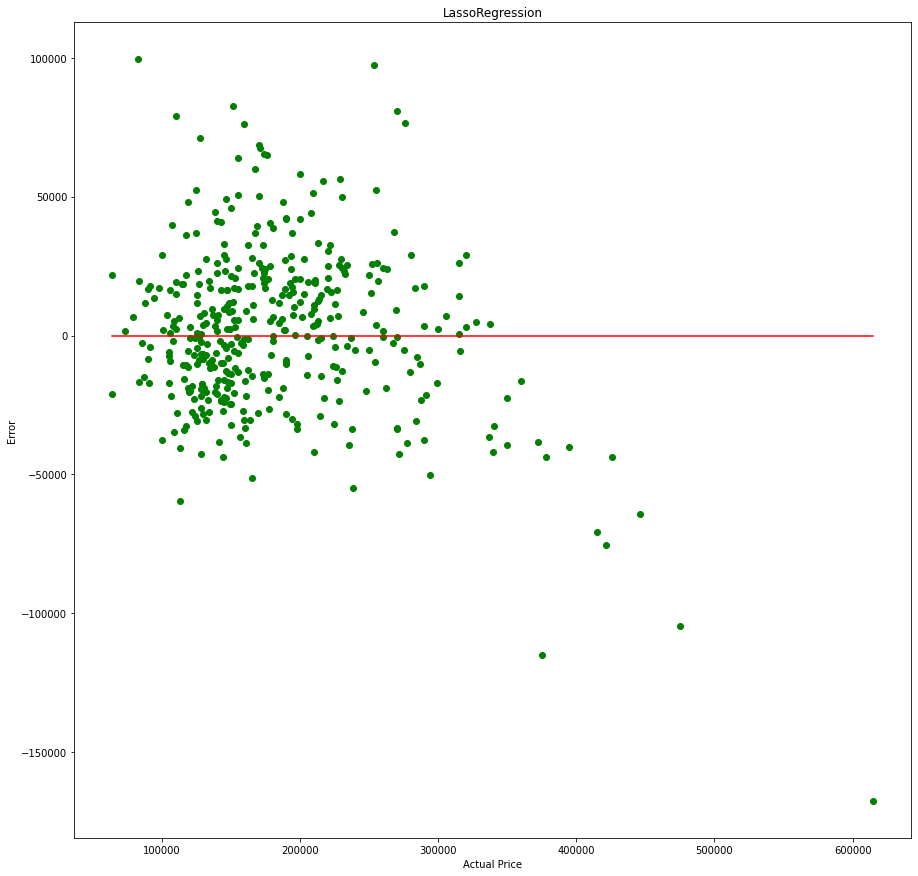

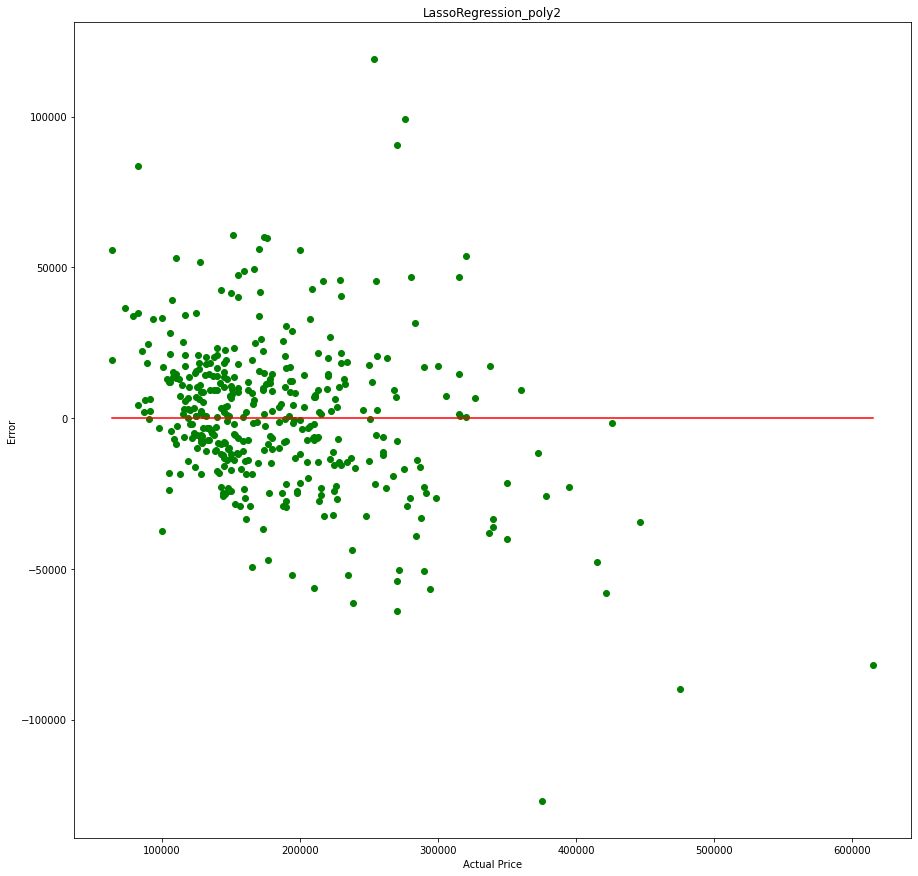

In [70]:
from sklearn.linear_model import Lasso
ls=Lasso(alpha=0.5,max_iter=1000,random_state=0)
model_test(ls,data,target,0.3,'LassoRegression')

ls2=Lasso(alpha=0.5,max_iter=1000,random_state=0)
model_test(ls2,X_poly2,target,0.3,'LassoRegression_poly2')


NMAE SCORE :  0.11905794293179756
R^2 SCORE :  0.8186570361283312
5- cvscore : 0.8330723143152395
NMAE SCORE :  0.10333376529675194
R^2 SCORE :  0.8612680737612043
5- cvscore : 0.8835975942293658


,target
841,8641.772019
184,-7423.621217
526,-2877.929703
1283,3921.090056
980,-137831.894282
...,...
619,-10663.856144
122,22447.091830
1015,19157.139100
990,-35069.751699


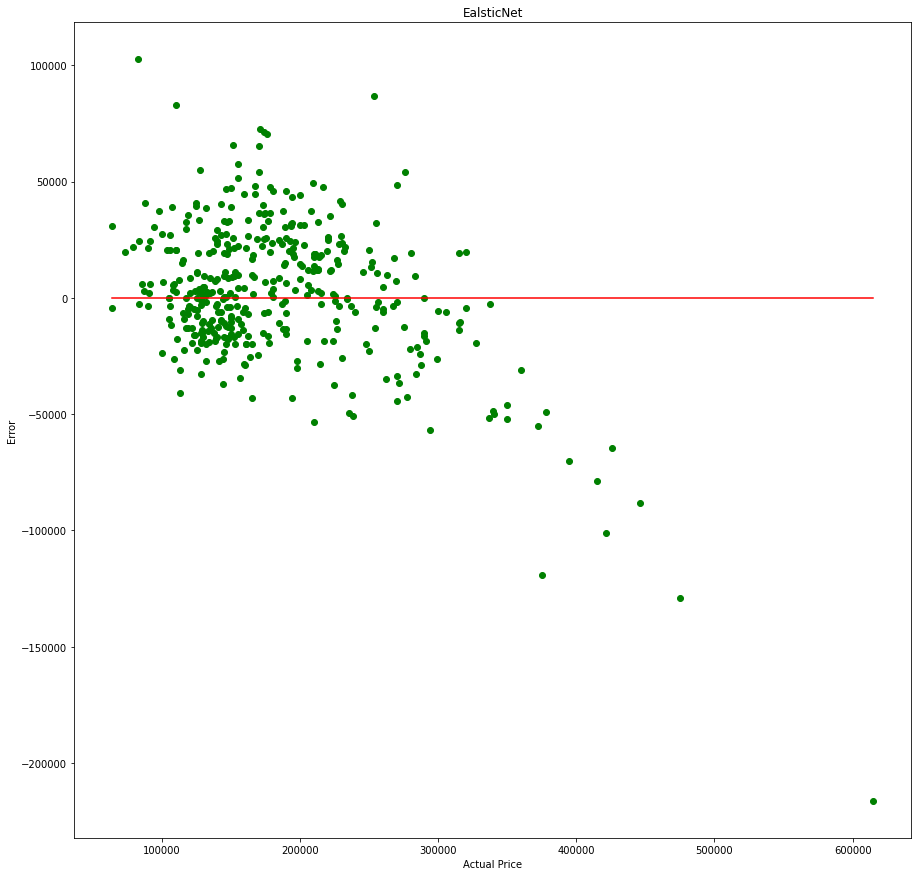

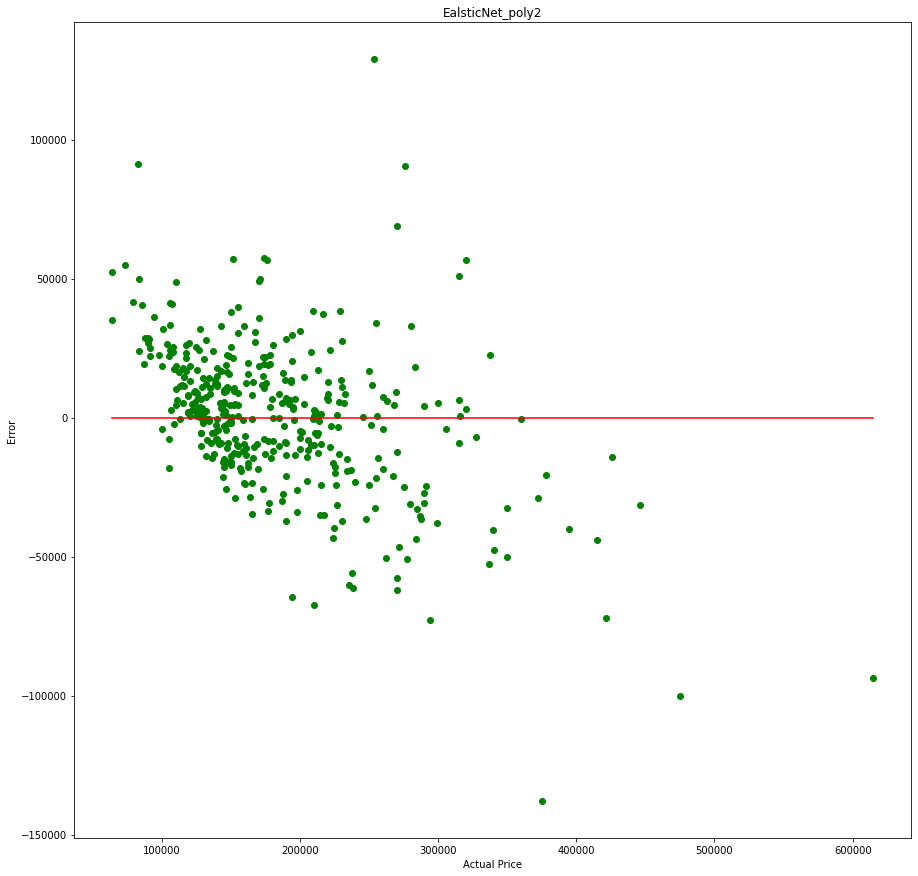

In [71]:
from sklearn.linear_model import ElasticNet

et=ElasticNet(alpha=0.8,max_iter=1000,random_state=0)
model_test(et,data,target,0.3,'EalsticNet')

et=ElasticNet(alpha=0.8,max_iter=1000,random_state=0)
model_test(et,X_poly2,target,0.3,'EalsticNet_poly2')

In [72]:
model_rank

,NMAE score,R^2 score,cv score
LinearRegression,0.12050,0.82788,0.851518
PolynomialRegression,0.10070,0.87129,0.894482
PolynomialRegression3,0.11845,0.80676,0.776315
PolynomialRegression4,100.00000,-100.00000,100.000000
SGERegressor,0.12018,0.82826,0.851679
SGERegressor+poly2,0.10469,0.85621,0.884414
RidgeRegression,0.12049,0.82790,0.851527
RidgeRegression_poly2,0.10065,0.87136,0.894543
RidgeRegression_poly3,0.11533,0.81906,0.792077
LassoRegression,0.12050,0.82788,0.851518


learning rate가 커질수록 높은 가격은 높게 추측함

C:\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war

NMAE SCORE :  0.1201798673058125
R^2 SCORE :  0.8282551377977497
5- cvscore : 0.8516792880149051
NMAE SCORE :  0.10468948733600864
R^2 SCORE :  0.8562130235216346
5- cvscore : 0.8844140100530063


C:\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war

,target
841,12297.440128
184,1760.331445
526,-12762.785339
1283,-414.520273
980,-122603.801809
...,...
619,-11667.237371
122,10611.268290
1015,8536.616404
990,-37655.765391


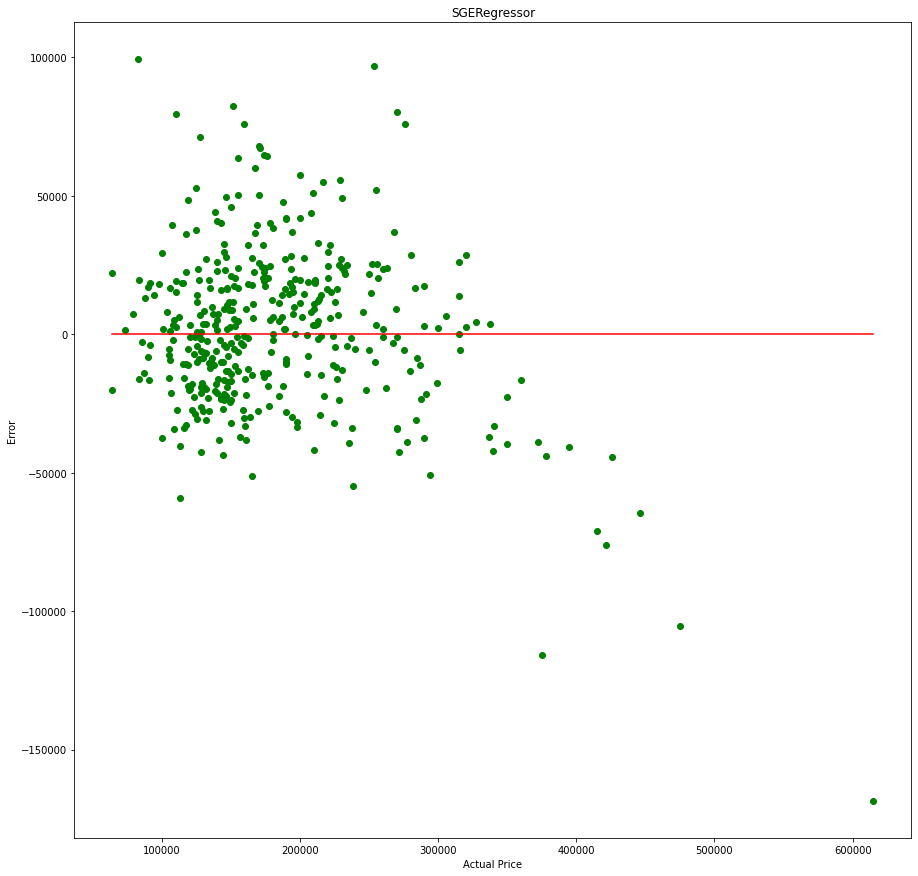

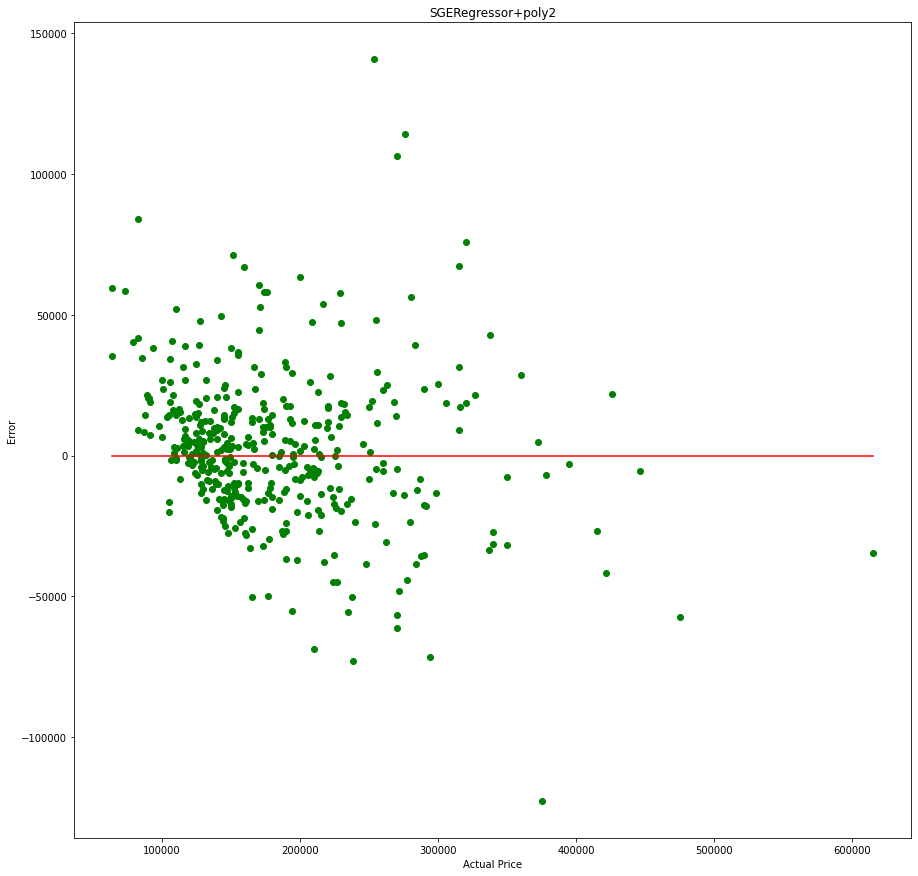

In [66]:
from sklearn.linear_model import SGDRegressor

SGD=SGDRegressor(max_iter=1000,random_state=0)
model_test(SGD,data,target,0.3,'SGERegressor')

SGD=SGDRegressor(max_iter=1000,random_state=0)
model_test(SGD,X_poly2,target,0.3,'SGERegressor+poly2')

In [67]:
model_rank

,NMAE score,R^2 score,cv score
LinearRegression,0.12050,0.82788,0.851518
PolynomialRegression,0.10070,0.87129,0.894482
PolynomialRegression3,0.11845,0.80676,0.776315
PolynomialRegression4,100.00000,-100.00000,100.000000
SGERegressor,0.12018,0.82826,0.851679
SGERegressor+poly2,0.10469,0.85621,0.884414


## 3.Random Forest

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_12632/4180123040.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

NMAE SCORE :  0.08651782426649837
R^2 SCORE :  0.8276507535833185
5- cvscore : 0.8254703299223995


C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_12632/4180123040.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

NMAE SCORE :  0.09177543088152149
R^2 SCORE :  0.8087402866784472
5- cvscore : 0.8270693996640442


C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_12632/4180123040.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

NMAE SCORE :  0.08991896447052135
R^2 SCORE :  0.8183465780237192
5- cvscore : 0.8185667101758554


,overvalued
711,-5840.098493
980,15094.141326
1041,-33235.069282
902,22280.732698
520,75008.863759
...,...
531,-4544.678649
769,-17083.551122
315,-2037.664751
702,-6683.935509


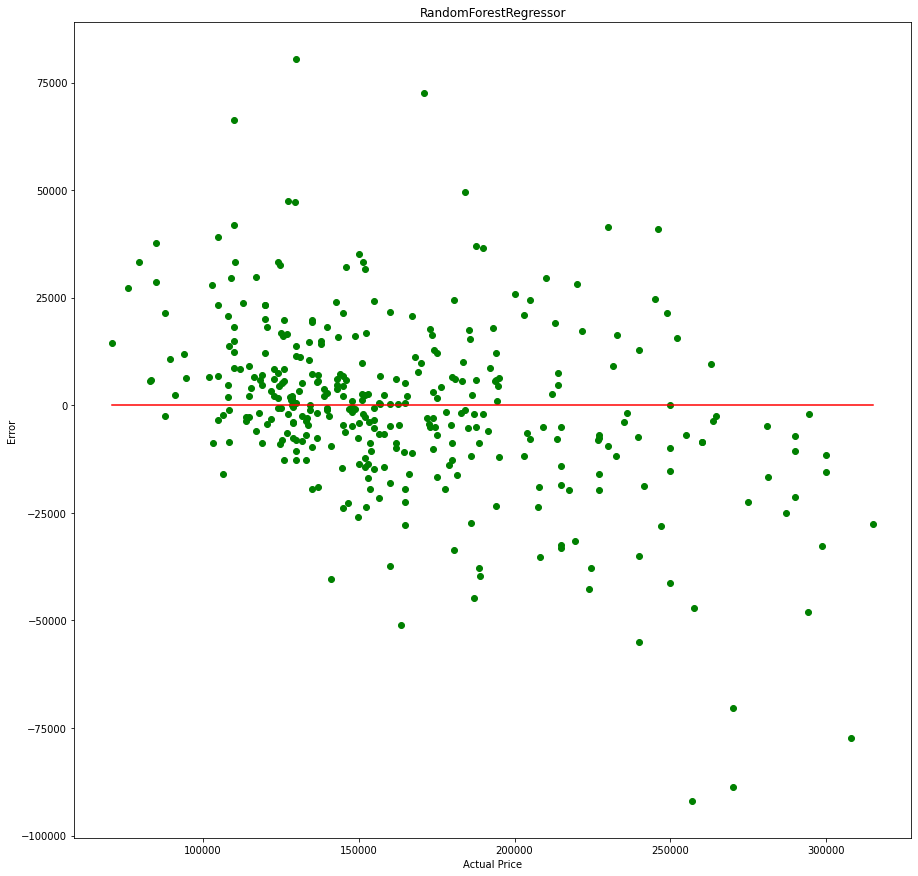

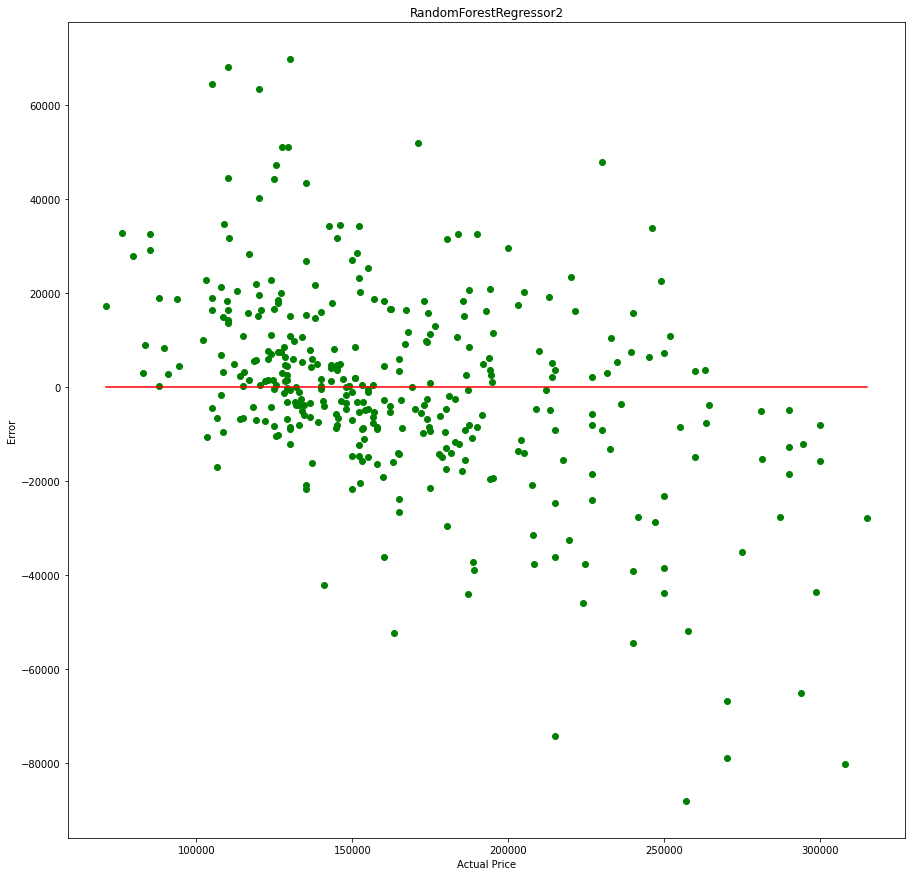

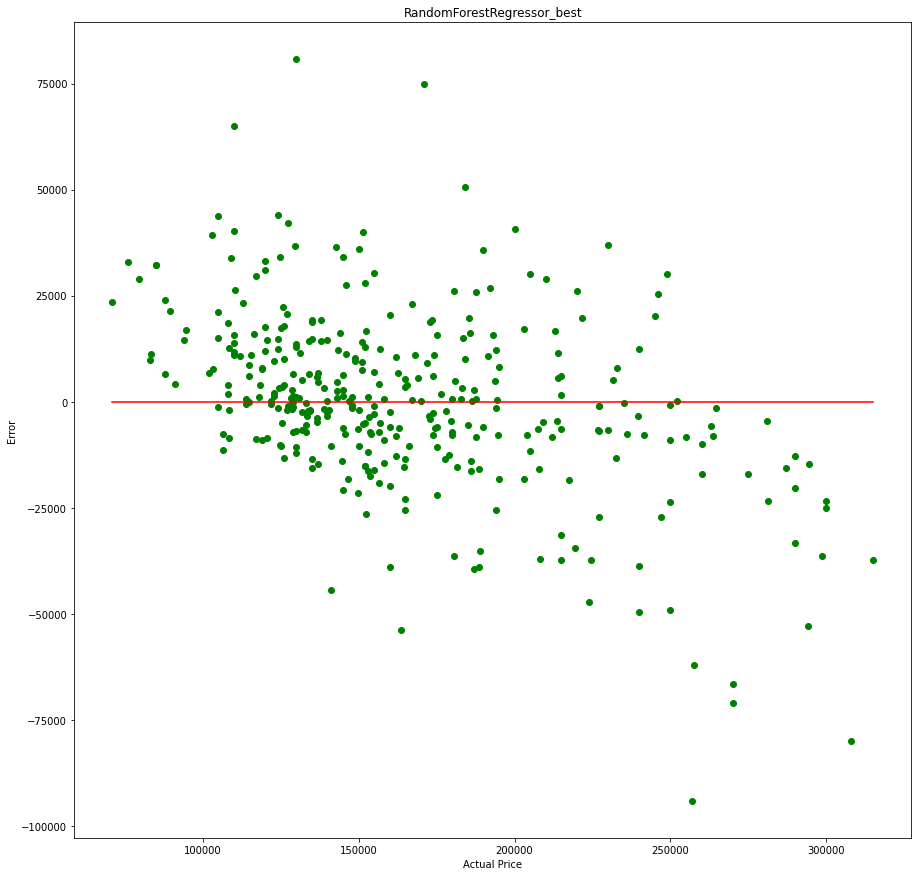

In [644]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100,random_state=0)
model_test(rf,data,target,0.3,'RandomForestRegressor')

rf2 = RandomForestRegressor(n_estimators=100,random_state=0)
model_test(rf2,X_poly2,target,0.3,'RandomForestRegressor2')

rf_best = RandomForestRegressor(n_estimators=1000,random_state=0,max_depth=10,min_samples_leaf=8,min_samples_split=8)
model_test(rf_best,data,target,0.3,'RandomForestRegressor_best')

In [650]:
dif.sort_values('overvalued')

,overvalued
303,-78568.713338
1039,-74721.937624
1053,-73772.389890
867,-72272.113529
1169,-71057.705550
...,...
706,51968.422618
202,52792.784286
564,71918.104540
200,78426.326460


In [313]:
params ={
    'n_estimators' : [800,1000,1200,1400,1600],
    'max_depth' : [8,10],
    'min_samples_leaf' : [1,2,8],
    'min_samples_split' : [1,2,8]
}

rf = RandomForestRegressor(random_state=0)
best=best_params(rf,params)

C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

KeyError: 0

In [333]:
best

,params,mean_fit_time,mean_test_score
0,"{'max_depth': 10, 'min_samples_leaf': 8, 'min_...",3.155143,-16154.326564
2,"{'max_depth': 10, 'min_samples_leaf': 8, 'min_...",4.410333,-16158.859450
1,"{'max_depth': 10, 'min_samples_leaf': 8, 'min_...",3.701496,-16160.721275
3,"{'max_depth': 10, 'min_samples_leaf': 8, 'min_...",4.771546,-16172.925235


In [365]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor #XGB회귀
from lightgbm import LGBMRegressor #LGB회귀


rf_best = RandomForestRegressor(random_state=0)

params_rf ={
    'n_estimators' : [800,1000,1200,1400,1600],
    'max_depth' : [8,10],
    'min_samples_leaf' : [1,2,8],
    'min_samples_split' : [1,2,8]
}
GBR = GradientBoostingRegressor(n_estimators=200,learning_rate=0.1,random_state=0,loss='absolute_error')

params_gbm = {
    'loss' : ['absolute_error','squared_error'],
    'n_estimators' : [100,200,400,800],
    'learning_rate' : [0.1,0.2,0.4,0.8]
}

tr
params_xgb={
    'learning_rate' : [0.1,0.3,0.9],
    'n_estimators' : [100,200,400,800],
    'max_depth' : [6,8,10,12]
}

LGBM = LGBMRegressor(random_state=0)
params_lightgbm={
    
}

model = [[rf_best,params_rf],[GBR,params_gbm],[XGB,params_xgb]]

for i in range(0,3):
    best.add(best_params(model[i][0],model[i][1]))


C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Python39\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Python39\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Python39\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._d

AttributeError: 'RandomForestRegressor' object has no attribute 'estimators_'

In [366]:
best

,params,mean_fit_time,mean_test_score
0,"{'max_depth': 10, 'min_samples_leaf': 8, 'min_...",3.155143,-16154.326564
2,"{'max_depth': 10, 'min_samples_leaf': 8, 'min_...",4.410333,-16158.859450
1,"{'max_depth': 10, 'min_samples_leaf': 8, 'min_...",3.701496,-16160.721275
3,"{'max_depth': 10, 'min_samples_leaf': 8, 'min_...",4.771546,-16172.925235


C:\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Pytho

NMAE SCORE :  0.08569878618648788
R^2 SCORE :  0.8345738888259993
5- cvscore : 0.8302967239228316


C:\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Pytho

NMAE SCORE :  0.08833955579525396
R^2 SCORE :  0.8229249993695694
5- cvscore : 0.8303972449881915


,overvalued
711,-2799.168705
980,17481.033014
1041,-22322.645521
902,-386.224980
520,43199.588547
...,...
531,-5322.827117
769,-16605.579243
315,3841.570811
702,-7925.742104


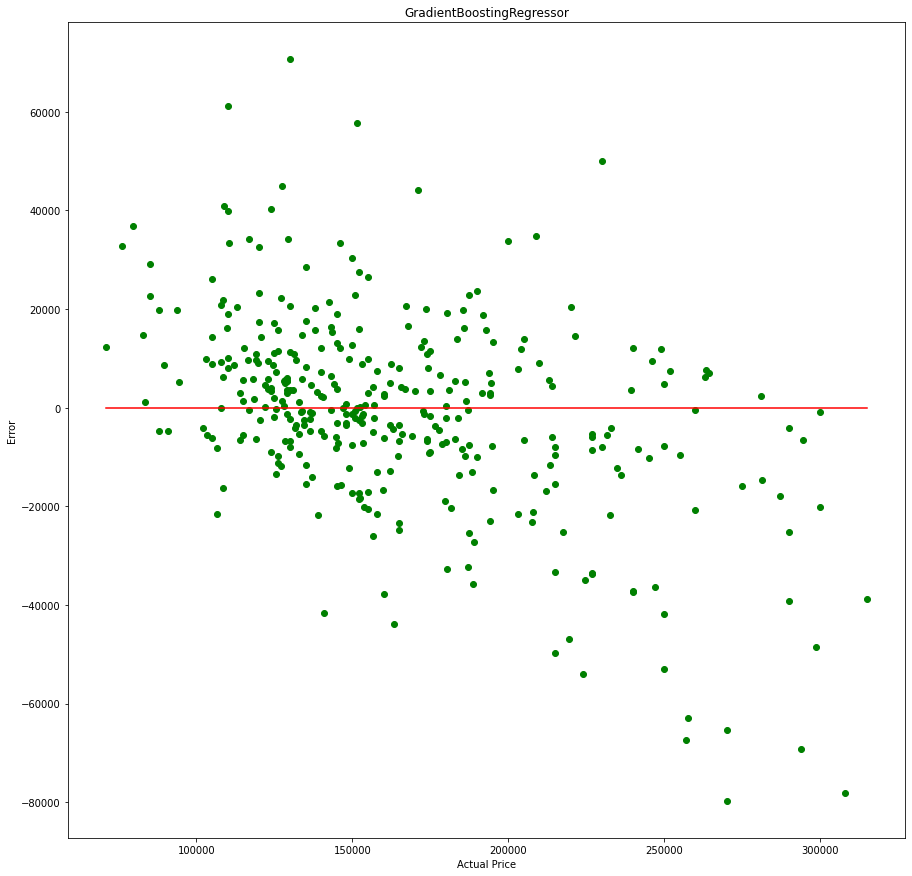

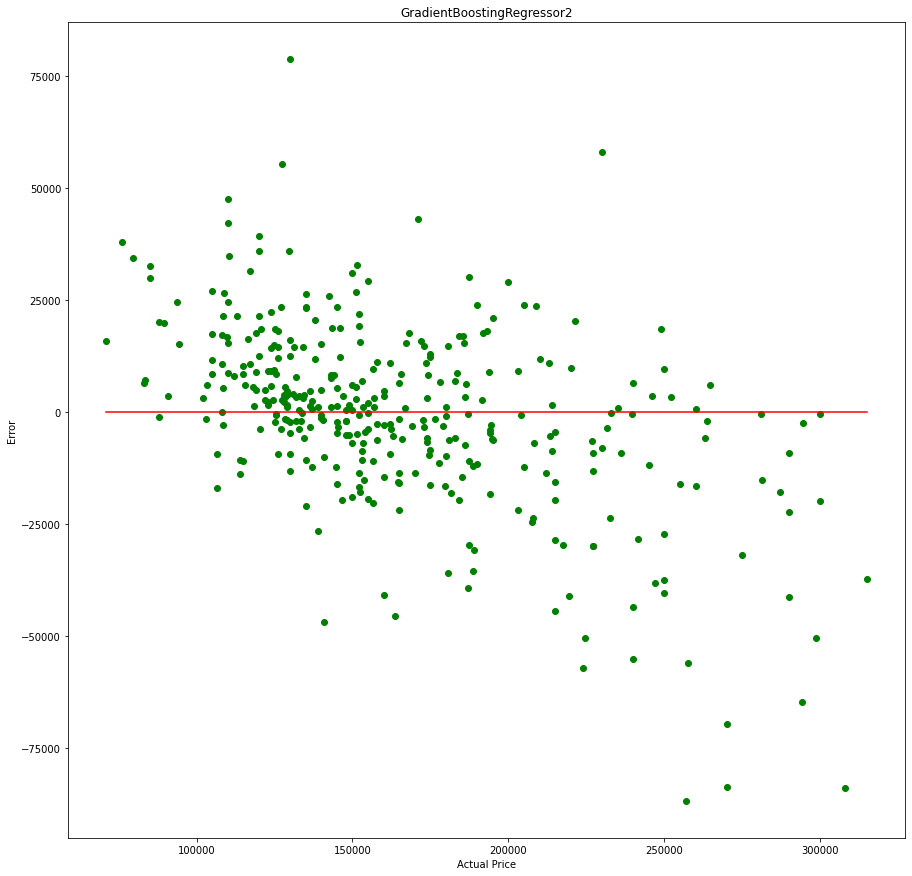

In [645]:
GBR = GradientBoostingRegressor(n_estimators=200,learning_rate=0.1,random_state=0,loss='absolute_error')
dif_gbr=model_test(GBR,data,target,0.3,'GradientBoostingRegressor')


GBR2 = GradientBoostingRegressor(n_estimators=200,learning_rate=0.1,random_state=0,loss='absolute_error')
model_test(GBR2,X_poly2,target,0.3,'GradientBoostingRegressor2')

In [647]:
model_rank

,NMAE score,R^2 score,cv score
RidgeRegression,0.09847,0.80617,0.828258
RidgeRegression_poly2,0.09362,0.81242,0.830838
RidgeRegression_alpha41,0.09907,0.80388,0.828004
LassoRegression,0.09847,0.80619,0.828247
LassoRegression_poly2,0.09392,0.81079,0.830519
EalsticNet,0.10277,0.78348,0.810668
EalsticNet_poly2,0.09270,0.81678,0.832942
SGERegressor,0.09793,0.80692,0.828594
SGERegressor+poly2,0.10145,0.78617,0.815932
RandomForestRegressor,0.08652,0.82765,0.825470


In [651]:
dif_gbr.sort_values('target')

KeyError: 'target'

In [652]:
GBR_L = GradientBoostingRegressor(n_estimators=200,learning_rate=0.1,random_state=0,loss='absolute_error')
rf_L = RandomForestRegressor(n_estimators=100,random_state=0)

GBR_L.fit(data,target),rf_L.fit(data,target)

C:\Python39\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_12632/2097015868.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  GBR_L.fit(data,target),rf_L.fit(data,target)


(GradientBoostingRegressor(loss='absolute_error', n_estimators=200,
                           random_state=0),
 RandomForestRegressor(random_state=0))

In [655]:
ans=GBR_L.predict(test_data) + rf_L.predict(test_data)

In [657]:
ans=ans/2

In [ ]:
def make_submission(model):
    z=pd.read_csv('./housing/sample_submission.csv')
    y=model.predict(test_data)
    z['target']=y
    z.set_index('id',inplace=True)
    
    return z

#z = make_submission(model)
#z.to_csv('deep_3700.csv')

In [658]:
z=pd.read_csv('./housing/sample_submission.csv')
z['target']=ans

In [660]:
 z.set_index('id',inplace=True)

In [663]:
z.to_csv('rf+gbm.csv')

In [666]:
y=pd.read_csv('./dacondeep_3300_all.csv')
y.set_index('id',inplace=True)


In [670]:
k=(z+y)/2

In [671]:
k.to_csv('rf+gbm+deep.csv')

### 3. 딥러닝

In [672]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


In [673]:
def build_model():
    model = keras.Sequential([
        layers.Dense(96,activation = 'relu', input_shape=[13]),
        layers.Dense(64,activation = 'relu'),
        layers.Dense(32,activation = 'relu'),
        layers.Dense(1)
    ])
    
    model.compile(loss = 'mse',
                 optimizer = 'rmsprop',
                 metrics=['mae','mse'])
    
    return model

In [674]:
model = build_model()

In [675]:
model.summary()
# 14 * 64
# 65 * 64
# 65 * 1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                1344      
                                                                 
 dense_1 (Dense)             (None, 64)                6208      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9,665
Trainable params: 9,665
Non-trainable params: 0
_________________________________________________________________


In [676]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 50 == 0: print('')
        print('.', end='')

EPOCHS = 4000

history = model.fit(
  data, target,
  epochs=EPOCHS, validation_split = 0.2, verbose=10,
  callbacks=[PrintDot()])

Epoch 1/4000

.Epoch 2/4000
.Epoch 3/4000
.Epoch 4/4000
.Epoch 5/4000
.Epoch 6/4000
.Epoch 7/4000
.Epoch 8/4000
.Epoch 9/4000
.Epoch 10/4000
.Epoch 11/4000
.Epoch 12/4000
.Epoch 13/4000
.Epoch 14/4000
.Epoch 15/4000
.Epoch 16/4000
.Epoch 17/4000
.Epoch 18/4000
.Epoch 19/4000
.Epoch 20/4000
.Epoch 21/4000
.Epoch 22/4000
.Epoch 23/4000
.Epoch 24/4000
.Epoch 25/4000
.Epoch 26/4000
.Epoch 27/4000
.Epoch 28/4000
.Epoch 29/4000
.Epoch 30/4000
.Epoch 31/4000
.Epoch 32/4000
.Epoch 33/4000
.Epoch 34/4000
.Epoch 35/4000
.Epoch 36/4000
.Epoch 37/4000
.Epoch 38/4000
.Epoch 39/4000
.Epoch 40/4000
.Epoch 41/4000
.Epoch 42/4000
.Epoch 43/4000
.Epoch 44/4000
.Epoch 45/4000
.Epoch 46/4000
.Epoch 47/4000
.Epoch 48/4000
.Epoch 49/4000
.Epoch 50/4000
.Epoch 51/4000

.Epoch 52/4000
.Epoch 53/4000
.Epoch 54/4000
.Epoch 55/4000
.Epoch 56/4000
.Epoch 57/4000
.Epoch 58/4000
.Epoch 59/4000
.Epoch 60/4000
.Epoch 61/4000
.Epoch 62/4000
.Epoch 63/4000
.Epoch 64/4000
.Epoch 65/4000
.Epoch 66/4000
.Epoch 67/4000
.Ep

.Epoch 523/4000
.Epoch 524/4000
.Epoch 525/4000
.Epoch 526/4000
.Epoch 527/4000
.Epoch 528/4000
.Epoch 529/4000
.Epoch 530/4000
.Epoch 531/4000
.Epoch 532/4000
.Epoch 533/4000
.Epoch 534/4000
.Epoch 535/4000
.Epoch 536/4000
.Epoch 537/4000
.Epoch 538/4000
.Epoch 539/4000
.Epoch 540/4000
.Epoch 541/4000
.Epoch 542/4000
.Epoch 543/4000
.Epoch 544/4000
.Epoch 545/4000
.Epoch 546/4000
.Epoch 547/4000
.Epoch 548/4000
.Epoch 549/4000
.Epoch 550/4000
.Epoch 551/4000

.Epoch 552/4000
.Epoch 553/4000
.Epoch 554/4000
.Epoch 555/4000
.Epoch 556/4000
.Epoch 557/4000
.Epoch 558/4000
.Epoch 559/4000
.Epoch 560/4000
.Epoch 561/4000
.Epoch 562/4000
.Epoch 563/4000
.Epoch 564/4000
.Epoch 565/4000
.Epoch 566/4000
.Epoch 567/4000
.Epoch 568/4000
.Epoch 569/4000
.Epoch 570/4000
.Epoch 571/4000
.Epoch 572/4000
.Epoch 573/4000
.Epoch 574/4000
.Epoch 575/4000
.Epoch 576/4000
.Epoch 577/4000
.Epoch 578/4000
.Epoch 579/4000
.Epoch 580/4000
.Epoch 581/4000
.Epoch 582/4000
.Epoch 583/4000
.Epoch 584/4000
.Epoch 

.Epoch 1036/4000
.Epoch 1037/4000
.Epoch 1038/4000
.Epoch 1039/4000
.Epoch 1040/4000
.Epoch 1041/4000
.Epoch 1042/4000
.Epoch 1043/4000
.Epoch 1044/4000
.Epoch 1045/4000
.Epoch 1046/4000
.Epoch 1047/4000
.Epoch 1048/4000
.Epoch 1049/4000
.Epoch 1050/4000
.Epoch 1051/4000

.Epoch 1052/4000
.Epoch 1053/4000
.Epoch 1054/4000
.Epoch 1055/4000
.Epoch 1056/4000
.Epoch 1057/4000
.Epoch 1058/4000
.Epoch 1059/4000
.Epoch 1060/4000
.Epoch 1061/4000
.Epoch 1062/4000
.Epoch 1063/4000
.Epoch 1064/4000
.Epoch 1065/4000
.Epoch 1066/4000
.Epoch 1067/4000
.Epoch 1068/4000
.Epoch 1069/4000
.Epoch 1070/4000
.Epoch 1071/4000
.Epoch 1072/4000
.Epoch 1073/4000
.Epoch 1074/4000
.Epoch 1075/4000
.Epoch 1076/4000
.Epoch 1077/4000
.Epoch 1078/4000
.Epoch 1079/4000
.Epoch 1080/4000
.Epoch 1081/4000
.Epoch 1082/4000
.Epoch 1083/4000
.Epoch 1084/4000
.Epoch 1085/4000
.Epoch 1086/4000
.Epoch 1087/4000
.Epoch 1088/4000
.Epoch 1089/4000
.Epoch 1090/4000
.Epoch 1091/4000
.Epoch 1092/4000
.Epoch 1093/4000
.Epoch 1094/4

.Epoch 1518/4000
.Epoch 1519/4000
.Epoch 1520/4000
.Epoch 1521/4000
.Epoch 1522/4000
.Epoch 1523/4000
.Epoch 1524/4000
.Epoch 1525/4000
.Epoch 1526/4000
.Epoch 1527/4000
.Epoch 1528/4000
.Epoch 1529/4000
.Epoch 1530/4000
.Epoch 1531/4000
.Epoch 1532/4000
.Epoch 1533/4000
.Epoch 1534/4000
.Epoch 1535/4000
.Epoch 1536/4000
.Epoch 1537/4000
.Epoch 1538/4000
.Epoch 1539/4000
.Epoch 1540/4000
.Epoch 1541/4000
.Epoch 1542/4000
.Epoch 1543/4000
.Epoch 1544/4000
.Epoch 1545/4000
.Epoch 1546/4000
.Epoch 1547/4000
.Epoch 1548/4000
.Epoch 1549/4000
.Epoch 1550/4000
.Epoch 1551/4000

.Epoch 1552/4000
.Epoch 1553/4000
.Epoch 1554/4000
.Epoch 1555/4000
.Epoch 1556/4000
.Epoch 1557/4000
.Epoch 1558/4000
.Epoch 1559/4000
.Epoch 1560/4000
.Epoch 1561/4000
.Epoch 1562/4000
.Epoch 1563/4000
.Epoch 1564/4000
.Epoch 1565/4000
.Epoch 1566/4000
.Epoch 1567/4000
.Epoch 1568/4000
.Epoch 1569/4000
.Epoch 1570/4000
.Epoch 1571/4000
.Epoch 1572/4000
.Epoch 1573/4000
.Epoch 1574/4000
.Epoch 1575/4000
.Epoch 1576/4

.Epoch 2001/4000

.Epoch 2002/4000
.Epoch 2003/4000
.Epoch 2004/4000
.Epoch 2005/4000
.Epoch 2006/4000
.Epoch 2007/4000
.Epoch 2008/4000
.Epoch 2009/4000
.Epoch 2010/4000
.Epoch 2011/4000
.Epoch 2012/4000
.Epoch 2013/4000
.Epoch 2014/4000
.Epoch 2015/4000
.Epoch 2016/4000
.Epoch 2017/4000
.Epoch 2018/4000
.Epoch 2019/4000
.Epoch 2020/4000
.Epoch 2021/4000
.Epoch 2022/4000
.Epoch 2023/4000
.Epoch 2024/4000
.Epoch 2025/4000
.Epoch 2026/4000
.Epoch 2027/4000
.Epoch 2028/4000
.Epoch 2029/4000
.Epoch 2030/4000
.Epoch 2031/4000
.Epoch 2032/4000
.Epoch 2033/4000
.Epoch 2034/4000
.Epoch 2035/4000
.Epoch 2036/4000
.Epoch 2037/4000
.Epoch 2038/4000
.Epoch 2039/4000
.Epoch 2040/4000
.Epoch 2041/4000
.Epoch 2042/4000
.Epoch 2043/4000
.Epoch 2044/4000
.Epoch 2045/4000
.Epoch 2046/4000
.Epoch 2047/4000
.Epoch 2048/4000
.Epoch 2049/4000
.Epoch 2050/4000
.Epoch 2051/4000

.Epoch 2052/4000
.Epoch 2053/4000
.Epoch 2054/4000
.Epoch 2055/4000
.Epoch 2056/4000
.Epoch 2057/4000
.Epoch 2058/4000
.Epoch 2059/

.Epoch 2485/4000
.Epoch 2486/4000
.Epoch 2487/4000
.Epoch 2488/4000
.Epoch 2489/4000
.Epoch 2490/4000
.Epoch 2491/4000
.Epoch 2492/4000
.Epoch 2493/4000
.Epoch 2494/4000
.Epoch 2495/4000
.Epoch 2496/4000
.Epoch 2497/4000
.Epoch 2498/4000
.Epoch 2499/4000
.Epoch 2500/4000
.Epoch 2501/4000

.Epoch 2502/4000
.Epoch 2503/4000
.Epoch 2504/4000
.Epoch 2505/4000
.Epoch 2506/4000
.Epoch 2507/4000
.Epoch 2508/4000
.Epoch 2509/4000
.Epoch 2510/4000
.Epoch 2511/4000
.Epoch 2512/4000
.Epoch 2513/4000
.Epoch 2514/4000
.Epoch 2515/4000
.Epoch 2516/4000
.Epoch 2517/4000
.Epoch 2518/4000
.Epoch 2519/4000
.Epoch 2520/4000
.Epoch 2521/4000
.Epoch 2522/4000
.Epoch 2523/4000
.Epoch 2524/4000
.Epoch 2525/4000
.Epoch 2526/4000
.Epoch 2527/4000
.Epoch 2528/4000
.Epoch 2529/4000
.Epoch 2530/4000
.Epoch 2531/4000
.Epoch 2532/4000
.Epoch 2533/4000
.Epoch 2534/4000
.Epoch 2535/4000
.Epoch 2536/4000
.Epoch 2537/4000
.Epoch 2538/4000
.Epoch 2539/4000
.Epoch 2540/4000
.Epoch 2541/4000
.Epoch 2542/4000
.Epoch 2543/4

.Epoch 2970/4000
.Epoch 2971/4000
.Epoch 2972/4000
.Epoch 2973/4000
.Epoch 2974/4000
.Epoch 2975/4000
.Epoch 2976/4000
.Epoch 2977/4000
.Epoch 2978/4000
.Epoch 2979/4000
.Epoch 2980/4000
.Epoch 2981/4000
.Epoch 2982/4000
.Epoch 2983/4000
.Epoch 2984/4000
.Epoch 2985/4000
.Epoch 2986/4000
.Epoch 2987/4000
.Epoch 2988/4000
.Epoch 2989/4000
.Epoch 2990/4000
.Epoch 2991/4000
.Epoch 2992/4000
.Epoch 2993/4000
.Epoch 2994/4000
.Epoch 2995/4000
.Epoch 2996/4000
.Epoch 2997/4000
.Epoch 2998/4000
.Epoch 2999/4000
.Epoch 3000/4000
.Epoch 3001/4000

.Epoch 3002/4000
.Epoch 3003/4000
.Epoch 3004/4000
.Epoch 3005/4000
.Epoch 3006/4000
.Epoch 3007/4000
.Epoch 3008/4000
.Epoch 3009/4000
.Epoch 3010/4000
.Epoch 3011/4000
.Epoch 3012/4000
.Epoch 3013/4000
.Epoch 3014/4000
.Epoch 3015/4000
.Epoch 3016/4000
.Epoch 3017/4000
.Epoch 3018/4000
.Epoch 3019/4000
.Epoch 3020/4000
.Epoch 3021/4000
.Epoch 3022/4000
.Epoch 3023/4000
.Epoch 3024/4000
.Epoch 3025/4000
.Epoch 3026/4000
.Epoch 3027/4000
.Epoch 3028/4

.Epoch 3454/4000
.Epoch 3455/4000
.Epoch 3456/4000
.Epoch 3457/4000
.Epoch 3458/4000
.Epoch 3459/4000
.Epoch 3460/4000
.Epoch 3461/4000
.Epoch 3462/4000
.Epoch 3463/4000
.Epoch 3464/4000
.Epoch 3465/4000
.Epoch 3466/4000
.Epoch 3467/4000
.Epoch 3468/4000
.Epoch 3469/4000
.Epoch 3470/4000
.Epoch 3471/4000
.Epoch 3472/4000
.Epoch 3473/4000
.Epoch 3474/4000
.Epoch 3475/4000
.Epoch 3476/4000
.Epoch 3477/4000
.Epoch 3478/4000
.Epoch 3479/4000
.Epoch 3480/4000
.Epoch 3481/4000
.Epoch 3482/4000
.Epoch 3483/4000
.Epoch 3484/4000
.Epoch 3485/4000
.Epoch 3486/4000
.Epoch 3487/4000
.Epoch 3488/4000
.Epoch 3489/4000
.Epoch 3490/4000
.Epoch 3491/4000
.Epoch 3492/4000
.Epoch 3493/4000
.Epoch 3494/4000
.Epoch 3495/4000
.Epoch 3496/4000
.Epoch 3497/4000
.Epoch 3498/4000
.Epoch 3499/4000
.Epoch 3500/4000
.Epoch 3501/4000

.Epoch 3502/4000
.Epoch 3503/4000
.Epoch 3504/4000
.Epoch 3505/4000
.Epoch 3506/4000
.Epoch 3507/4000
.Epoch 3508/4000
.Epoch 3509/4000
.Epoch 3510/4000
.Epoch 3511/4000
.Epoch 3512/4

.Epoch 3936/4000
.Epoch 3937/4000
.Epoch 3938/4000
.Epoch 3939/4000
.Epoch 3940/4000
.Epoch 3941/4000
.Epoch 3942/4000
.Epoch 3943/4000
.Epoch 3944/4000
.Epoch 3945/4000
.Epoch 3946/4000
.Epoch 3947/4000
.Epoch 3948/4000
.Epoch 3949/4000
.Epoch 3950/4000
.Epoch 3951/4000

.Epoch 3952/4000
.Epoch 3953/4000
.Epoch 3954/4000
.Epoch 3955/4000
.Epoch 3956/4000
.Epoch 3957/4000
.Epoch 3958/4000
.Epoch 3959/4000
.Epoch 3960/4000
.Epoch 3961/4000
.Epoch 3962/4000
.Epoch 3963/4000
.Epoch 3964/4000
.Epoch 3965/4000
.Epoch 3966/4000
.Epoch 3967/4000
.Epoch 3968/4000
.Epoch 3969/4000
.Epoch 3970/4000
.Epoch 3971/4000
.Epoch 3972/4000
.Epoch 3973/4000
.Epoch 3974/4000
.Epoch 3975/4000
.Epoch 3976/4000
.Epoch 3977/4000
.Epoch 3978/4000
.Epoch 3979/4000
.Epoch 3980/4000
.Epoch 3981/4000
.Epoch 3982/4000
.Epoch 3983/4000
.Epoch 3984/4000
.Epoch 3985/4000
.Epoch 3986/4000
.Epoch 3987/4000
.Epoch 3988/4000
.Epoch 3989/4000
.Epoch 3990/4000
.Epoch 3991/4000
.Epoch 3992/4000
.Epoch 3993/4000
.Epoch 3994/4

In [677]:
y_pred=model.predict(test_data)

In [678]:
y_pred.shape

(1350, 1)

In [679]:
NMAE_R2(target,y_pred)

ValueError: Unable to coerce to DataFrame, shape must be (1194, 1): given (1350, 1)

In [680]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
3995,178927552.0,9908.507812,178927552.0,677322880.0,18414.126953,677322880.0,3995
3996,178514704.0,9946.877930,178514704.0,688934720.0,18829.677734,688934720.0,3996
3997,179337072.0,9963.646484,179337072.0,684143680.0,18517.957031,684143680.0,3997
3998,178882656.0,9936.730469,178882656.0,689516800.0,18848.005859,689516800.0,3998
3999,180840320.0,9990.511719,180840320.0,682582144.0,18687.876953,682582144.0,3999


In [681]:
hist['val_mae'][3000]

17030.8125

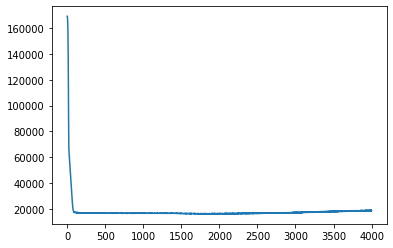

In [682]:
plt.plot(hist['epoch'],hist['val_mae'])

이때부터는 학습